In [1]:
import csv
import numpy as np

images, labels = [], []

with open('train.csv') as train_file:
    # Skip first line.
    train_file.readline()
    
    csv_train_file = csv.reader(train_file, delimiter=',')
    for row in csv_train_file:
        labels.append(row[0])
        images.append(np.array(row[1:], dtype=float))

In [2]:
##############################################################
#           Part One: Preprocess Data 1) Explore
##############################################################

Printing sample with label 8.


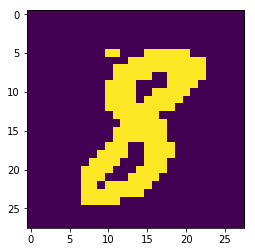

In [3]:
sample_index = 20

import matplotlib
from matplotlib import pyplot as plt

sample, label = images[sample_index], labels[sample_index]
plt.imshow(np.reshape(sample, (28, 28)), norm=matplotlib.colors.NoNorm())

print("Printing sample with label %s." % (label))
plt.show()

Printing sample with normalzied pixels.


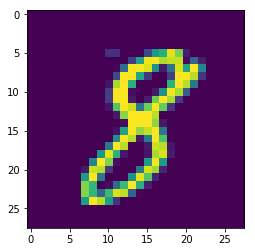

In [4]:
# Normalizing a sample to scale of (0, 1)

PIXEL_SCALE = 255
normalized_sample = sample / PIXEL_SCALE
plt.imshow(np.reshape(normalized_sample, (28, 28)), norm=matplotlib.colors.NoNorm())
print("Printing sample with normalzied pixels.")
plt.show()

In [5]:
normalized_images = [image / PIXEL_SCALE for image in images]

In [6]:
################################################################
#           Part One: Preprocess Data 2) Split Data Set
################################################################

In [7]:
# One hot encoding labels.
def one_hot_label(label):
    one_hot_coded = np.zeros(10)
    one_hot_coded[int(label)] = 1
    return np.array(one_hot_coded)

In [8]:
import random

combined = list(zip(images, labels))
random.shuffle(combined)
images[:], labels[:] = zip(*combined)

validation_size = int(len(images) / 10)

validate_images = [np.array(image).reshape((28, 28, 1)) for image in images[:validation_size]]
validate_labels = [one_hot_label(label) for label in labels[:validation_size]]

images = images[validation_size:]
labels = labels[validation_size:]


In [9]:
import tensorflow as tf

In [10]:
################################################################
#                Part Two: (1) Create Tensor
################################################################

In [11]:
def conv_net_input(input_shape):
    tensor_shape = [None] + list(input_shape)
    return tf.placeholder(tf.float32, shape=tensor_shape, name='conv_input')

def conv_net_label(label_shape):
    label_shape = [None, label_shape]
    return tf.placeholder(tf.float32, shape=label_shape, name='conv_label')

def conv_net_dropout_prob():
    return tf.placeholder(tf.float32, name='dropout_prob')

In [12]:
##############################################################
#                Part Two: (2) Create Layer
##############################################################

In [13]:
def bn_conv2d(input_tensor, kernel_depth=1, output_dim=32, k_size=3, padding='same'):
    """
    :param input_tensor: input tensor, should be reshaped to 2D
    :param output_dim: output dimension, e.g. 32, 64, etc. 
    :param kernel_size: kernel size, 3, 5, etc.
    """
    
    print('bn_conv2d: ', input_tensor.get_shape().as_list())
    
    conv_layer = tf.layers.conv2d(input_tensor,
                                  output_dim,
                                  k_size,
                                  padding=padding,
                                  activation=tf.nn.relu)
    
    return tf.layers.batch_normalization(conv_layer, training=True)

In [14]:
def max_pool(input_tensor, pool_ksize, pool_strides, padding='valid'):
    return tf.layers.max_pooling2d(
        input_tensor,
        pool_ksize,
        pool_strides,
        padding
    )

In [15]:
from functools import reduce

def flatten(input_tensor):
    image_dimension = reduce(lambda a,b: a*b, input_tensor.get_shape().as_list()[1:])    
    return tf.reshape(input_tensor, [-1, image_dimension])

In [16]:
def fully_connected_with_dropout(input_tensor, output_dim, dropout):
    
    print('fully input_tensor:', input_tensor.get_shape().as_list())
    
    fully_connected = tf.layers.dense(
        input_tensor,
        output_dim,
    )
    
    dropout_layer = tf.layers.dropout(inputs=fully_connected, rate=dropout)    
    
    return dropout_layer

In [17]:
def output_layer(input_tensor, output_dim):    
    return tf.layers.dense(
        input_tensor,
        output_dim,
    )

In [18]:
class BatchLoader:
    
    def __init__(self, images=[], label=[]):
        self.images = images
        self.labels = labels
        self.offset = 0
        
    def load_batch_image(self, batch_size):
        i = self.offset
        image_batch = self.images[i: i + batch_size]
        image_batch = [image.reshape((28, 28, 1)) for image in image_batch]       
        self.offset += batch_size
        return image_batch
        
    def load_batch(self, batch_size):        
        i = self.offset
        image_batch = self.images[i: i + batch_size]
        image_batch = [image.reshape((28, 28, 1)) for image in image_batch]
                
        label_batch = self.labels[i: i + batch_size]
        label_batch = [one_hot_label(label) for label in label_batch]
        self.offset += batch_size
                
        return image_batch, label_batch
        
    def reset(self):
        self.offset = 0

In [19]:
##############################################################
#                Part Two: (3) Create Model
##############################################################

In [20]:
def conv_net(image, dropout_prob):
    """
    :param image: input image tensor.
    :dropout_prob: drop out probability.
    """
    # convolution - max pooling layer 1
    conv_layer = bn_conv2d(image, kernel_depth=1, output_dim=32, k_size=5)
#     mp_layer = tf.layers.dropout(max_pool(conv_layer, 2, 2), rate=0.3)

    # convolution - max pooling layer 2
#     conv_layer = bn_conv2d(mp_layer, kernel_depth=32, output_dim=32, k_size=5)
    conv_layer = bn_conv2d(conv_layer, kernel_depth=32, output_dim=32, k_size=5)
    mp_layer = tf.layers.dropout(max_pool(conv_layer, 2, 2), rate=0.3)
    
    # convolution - max pooling layer 3
    conv_layer = bn_conv2d(mp_layer, kernel_depth=32, output_dim=64, k_size=3)
#     mp_layer = tf.layers.dropout(max_pool(conv_layer, 2, 2), rate=0.3)
            
#     conv_layer = bn_conv2d(mp_layer, kernel_depth=64, output_dim=64, k_size=3)
    conv_layer = bn_conv2d(conv_layer, kernel_depth=64, output_dim=64, k_size=3)
    mp_layer = tf.layers.dropout(max_pool(conv_layer, 2, 2), rate=0.3)

    flat = flatten(mp_layer)
    
    fully_conn = fully_connected_with_dropout(flat, 256, 0.5) 
        
    logits = output_layer(fully_conn, 10)
    
    return logits

In [21]:
##############################################################
#                Part Three: Define Loss & Accuracy
##############################################################

In [22]:
lr = 0.00001
conv_dropout = 0.3
fully_dropout = 0.5
batch_s = 600
epochs = 55

In [23]:
tf.reset_default_graph()

image_tensor = conv_net_input((28, 28, 1))
label_tensor = conv_net_label(10)
dropout_prob_tensor = conv_net_dropout_prob()

# Module

logits = conv_net(image_tensor, dropout_prob_tensor)
logits = tf.identity(logits, name='logits')

# Loss & Optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=label_tensor))
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

correct_pred = tf.equal(tf.argmax(logits, axis=1), tf.argmax(label_tensor, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

bn_conv2d:  [None, 28, 28, 1]
bn_conv2d:  [None, 28, 28, 32]
bn_conv2d:  [None, 14, 14, 32]
bn_conv2d:  [None, 14, 14, 64]
fully input_tensor: [None, 3136]


In [24]:
from functools import reduce
reduce((lambda a,b: a*b), [1,2], 1)

2

In [25]:
def print_stats(session,
                image_batch,
                label_batch,
                validation_image_batch,
                validation_label_batch,
                t_loss_seq,
                v_loss_seq
               ):
    
    t_loss = session.run(loss, feed_dict={
        image_tensor : image_batch,
        label_tensor : label_batch,
        dropout_prob_tensor : 0.0
    })
    
    t_loss_seq.append(t_loss)

    t_accuracy = session.run(accuracy, feed_dict={
        image_tensor : image_batch,
        label_tensor : label_batch,
        dropout_prob_tensor : 0.0     
    })
    
    v_loss = session.run(loss, feed_dict={
        image_tensor : validation_image_batch,
        label_tensor : validation_label_batch,
        dropout_prob_tensor : 0.0
    })
    
    v_loss_seq.append(v_loss)
    
    v_accuracy = session.run(accuracy, feed_dict={
        image_tensor : validation_image_batch,
        label_tensor : validation_label_batch,
        dropout_prob_tensor : 0.0     
    })
        
    print('Training loss: ', t_loss)
    print('Validation loss: ', v_loss)

    print('Training accuracy: ', t_accuracy)
    print('Validation accuracy: ', v_accuracy)



In [26]:
##############################################################
#                Part Four: Training
##############################################################

In [27]:
from matplotlib import pyplot as plt

In [28]:
def train_model(session, optimizer, image_batch, label_batch, dropout_prob):

    session.run(
        optimizer,
        feed_dict={
            image_tensor : image_batch,
            label_tensor : label_batch,
            dropout_prob_tensor : dropout_prob
        }
    )

In [29]:
save_model_path = './kaggle_digit'

def run_model(epochs, images, labels, batch_size, dropout_prob):
    
    t_loss_seq, v_loss_seq = [], []    
    
    with tf.Session() as session:
        
        # Initializing the variables
        session.run(tf.global_variables_initializer())
    
        # Prepare batches for images & labels
        loader = BatchLoader(images, labels)
    
        for epoch in range(epochs):
            
            loader.reset()
            
            count = 0
            
            while True:                
                image_batch, label_batch = loader.load_batch(batch_size)
                count += 1
                
                # Process each batch.
                if len(image_batch) != 0  and len(label_batch) != 0:                     
                    train_model(session, optimizer, image_batch, label_batch, dropout_prob)
                    
                    # Print stats every 30 iterations.
                    if count % 30 == 0:
                        print('===============epoch: ', epoch, '=================')
                        print_stats(session, image_batch, label_batch, 
                                    validate_images, validate_labels,
                                    t_loss_seq, v_loss_seq)
                        
                        ## Plot out training loss vs validation loss.
                        time_series = range(len(t_loss_seq))
                        plt.plot(time_series, t_loss_seq)
                        plt.plot(time_series, v_loss_seq)
                        plt.legend(['training_loss', 'validation_loss'])

                        plt.show()
                else:
                    break
                    
        saver = tf.train.Saver()
        save_path = saver.save(session, save_model_path)
                    

            

===============epoch:  0 =================
Training loss:  2.18844
Validation loss:  2.04795
Training accuracy:  0.346667
Validation accuracy:  0.371905


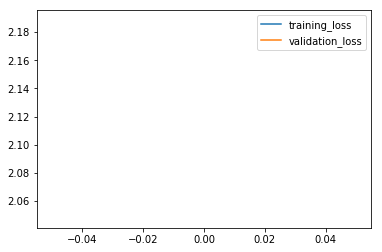

===============epoch:  0 =================
Training loss:  1.29571
Validation loss:  1.19616
Training accuracy:  0.611667
Validation accuracy:  0.61619


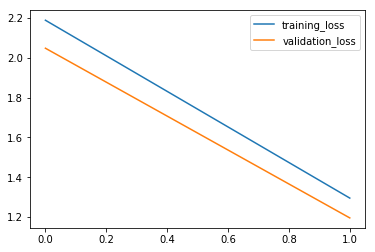

===============epoch:  1 =================
Training loss:  0.900215
Validation loss:  0.810038
Training accuracy:  0.713333
Validation accuracy:  0.742381


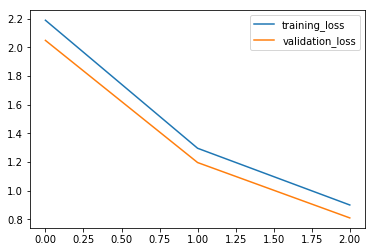

===============epoch:  1 =================
Training loss:  0.710585
Validation loss:  0.634715
Training accuracy:  0.771667
Validation accuracy:  0.797381


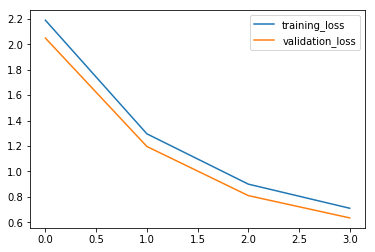

===============epoch:  2 =================
Training loss:  0.567402
Validation loss:  0.519464
Training accuracy:  0.806667
Validation accuracy:  0.833809


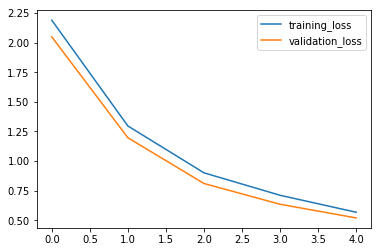

===============epoch:  2 =================
Training loss:  0.504479
Validation loss:  0.449728
Training accuracy:  0.841667
Validation accuracy:  0.857857


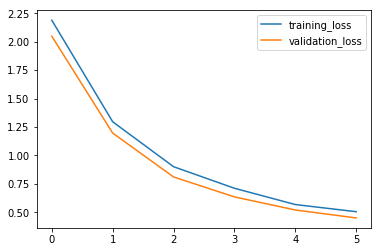

===============epoch:  3 =================
Training loss:  0.415047
Validation loss:  0.395896
Training accuracy:  0.858333
Validation accuracy:  0.874047


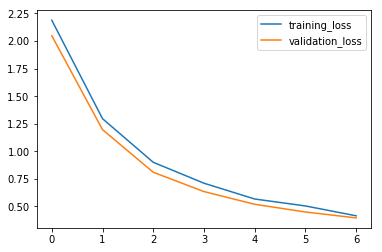

===============epoch:  3 =================
Training loss:  0.400962
Validation loss:  0.357475
Training accuracy:  0.878333
Validation accuracy:  0.885952


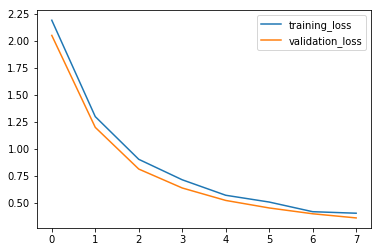

===============epoch:  4 =================
Training loss:  0.325671
Validation loss:  0.326255
Training accuracy:  0.896667
Validation accuracy:  0.897381


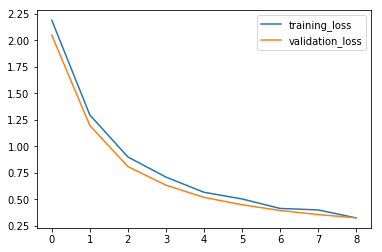

===============epoch:  4 =================
Training loss:  0.338498
Validation loss:  0.301
Training accuracy:  0.901667
Validation accuracy:  0.907619


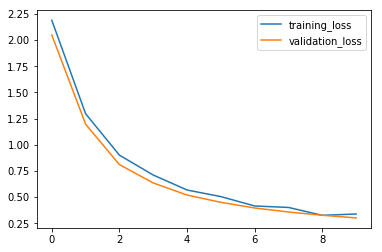

===============epoch:  5 =================
Training loss:  0.26725
Validation loss:  0.280512
Training accuracy:  0.92
Validation accuracy:  0.913333


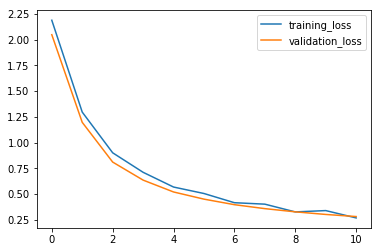

===============epoch:  5 =================
Training loss:  0.295708
Validation loss:  0.262327
Training accuracy:  0.91
Validation accuracy:  0.919762


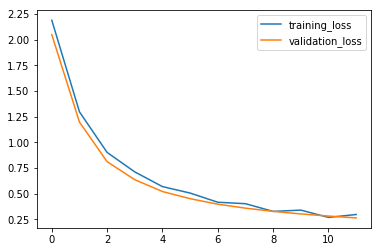

===============epoch:  6 =================
Training loss:  0.225909
Validation loss:  0.247739
Training accuracy:  0.933333
Validation accuracy:  0.920714


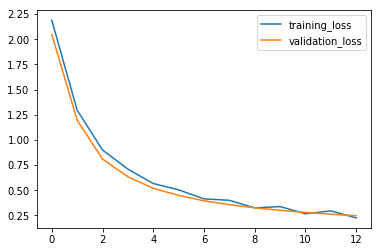

===============epoch:  6 =================
Training loss:  0.264405
Validation loss:  0.23386
Training accuracy:  0.918333
Validation accuracy:  0.925238


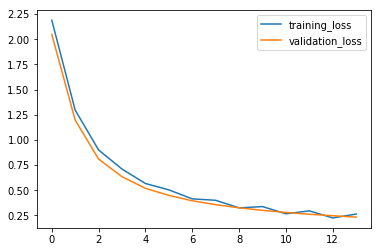

===============epoch:  7 =================
Training loss:  0.195591
Validation loss:  0.222859
Training accuracy:  0.943333
Validation accuracy:  0.928809


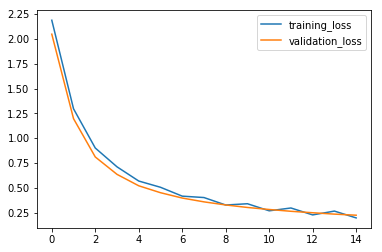

===============epoch:  7 =================
Training loss:  0.23999
Validation loss:  0.211899
Training accuracy:  0.923333
Validation accuracy:  0.930952


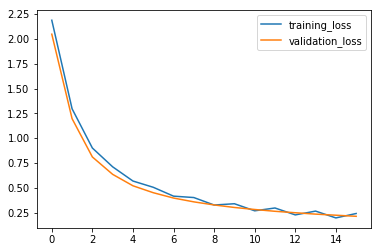

===============epoch:  8 =================
Training loss:  0.172371
Validation loss:  0.203248
Training accuracy:  0.955
Validation accuracy:  0.933571


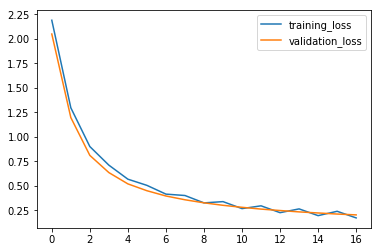

===============epoch:  8 =================
Training loss:  0.220146
Validation loss:  0.19435
Training accuracy:  0.931667
Validation accuracy:  0.937619


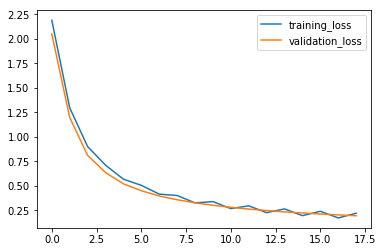

===============epoch:  9 =================
Training loss:  0.153891
Validation loss:  0.187352
Training accuracy:  0.958333
Validation accuracy:  0.939048


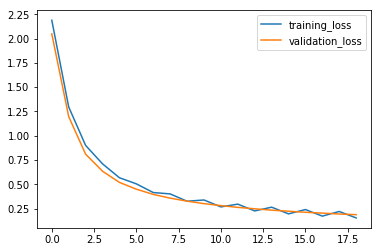

===============epoch:  9 =================
Training loss:  0.20373
Validation loss:  0.179951
Training accuracy:  0.938333
Validation accuracy:  0.941666


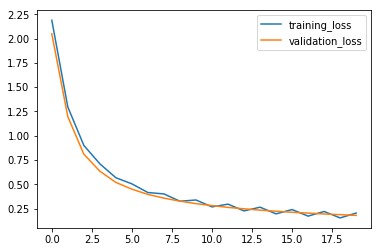

===============epoch:  10 =================
Training loss:  0.138918
Validation loss:  0.174187
Training accuracy:  0.965
Validation accuracy:  0.944762


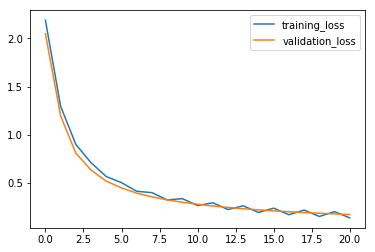

===============epoch:  10 =================
Training loss:  0.189517
Validation loss:  0.167894
Training accuracy:  0.943333
Validation accuracy:  0.947619


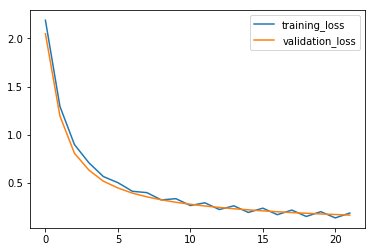

===============epoch:  11 =================
Training loss:  0.126472
Validation loss:  0.163061
Training accuracy:  0.965
Validation accuracy:  0.948571


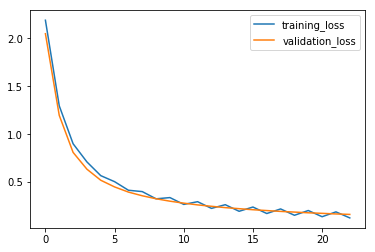

===============epoch:  11 =================
Training loss:  0.177255
Validation loss:  0.157663
Training accuracy:  0.951667
Validation accuracy:  0.949762


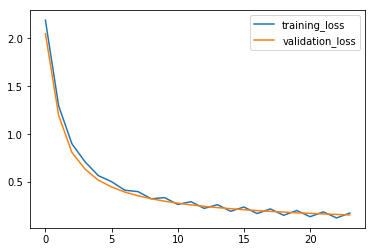

===============epoch:  12 =================
Training loss:  0.115943
Validation loss:  0.153541
Training accuracy:  0.966667
Validation accuracy:  0.950476


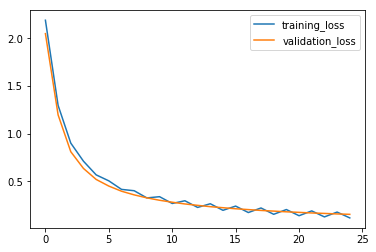

===============epoch:  12 =================
Training loss:  0.166572
Validation loss:  0.148904
Training accuracy:  0.953333
Validation accuracy:  0.952857


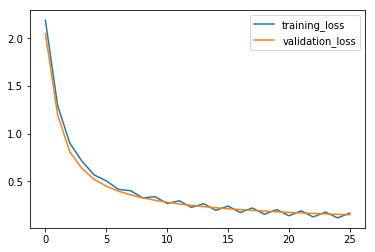

===============epoch:  13 =================
Training loss:  0.10689
Validation loss:  0.145385
Training accuracy:  0.968333
Validation accuracy:  0.953333


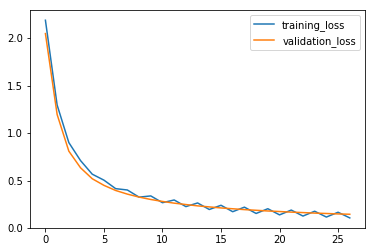

===============epoch:  13 =================
Training loss:  0.156894
Validation loss:  0.14133
Training accuracy:  0.955
Validation accuracy:  0.954047


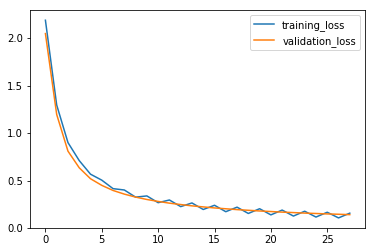

===============epoch:  14 =================
Training loss:  0.0990943
Validation loss:  0.138251
Training accuracy:  0.97
Validation accuracy:  0.955238


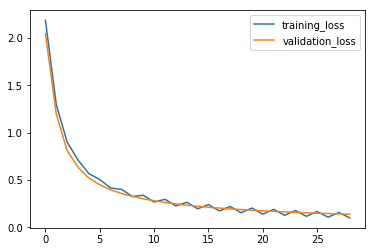

===============epoch:  14 =================
Training loss:  0.148115
Validation loss:  0.134695
Training accuracy:  0.956667
Validation accuracy:  0.956905


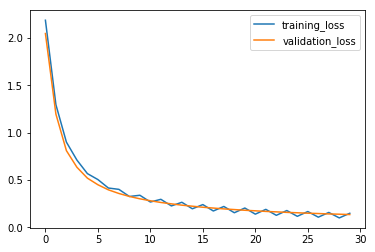

===============epoch:  15 =================
Training loss:  0.0923282
Validation loss:  0.132014
Training accuracy:  0.973333
Validation accuracy:  0.957619


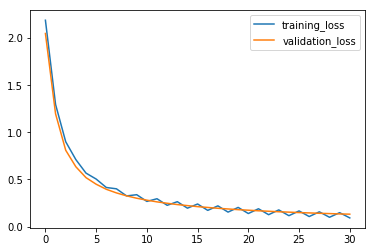

===============epoch:  15 =================
Training loss:  0.140079
Validation loss:  0.128869
Training accuracy:  0.961667
Validation accuracy:  0.958571


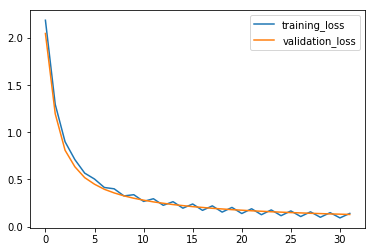

===============epoch:  16 =================
Training loss:  0.0863813
Validation loss:  0.1265
Training accuracy:  0.973333
Validation accuracy:  0.960238


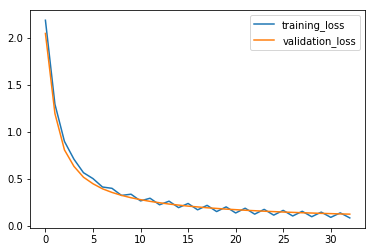

===============epoch:  16 =================
Training loss:  0.132737
Validation loss:  0.123743
Training accuracy:  0.963333
Validation accuracy:  0.960952


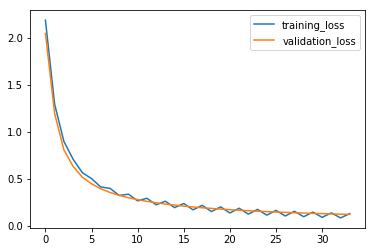

===============epoch:  17 =================
Training loss:  0.081042
Validation loss:  0.121614
Training accuracy:  0.973333
Validation accuracy:  0.962619


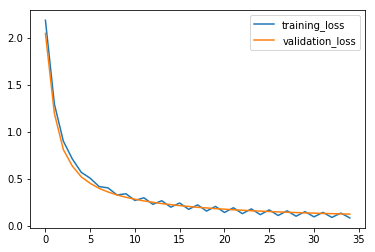

===============epoch:  17 =================
Training loss:  0.126026
Validation loss:  0.11916
Training accuracy:  0.965
Validation accuracy:  0.962143


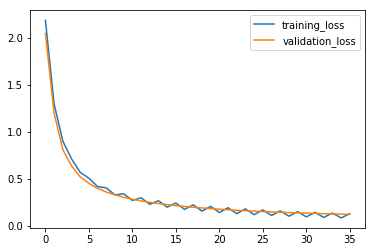

===============epoch:  18 =================
Training loss:  0.07627
Validation loss:  0.117274
Training accuracy:  0.973333
Validation accuracy:  0.964762


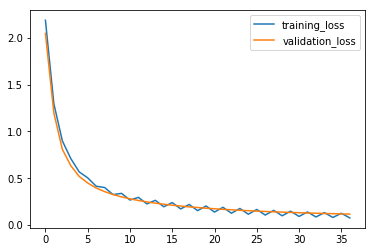

===============epoch:  18 =================
Training loss:  0.119774
Validation loss:  0.115097
Training accuracy:  0.965
Validation accuracy:  0.964524


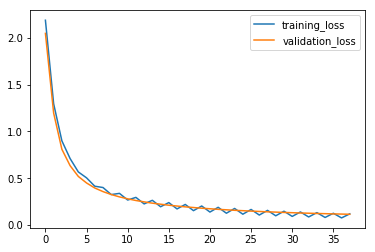

===============epoch:  19 =================
Training loss:  0.0719214
Validation loss:  0.113386
Training accuracy:  0.973333
Validation accuracy:  0.96619


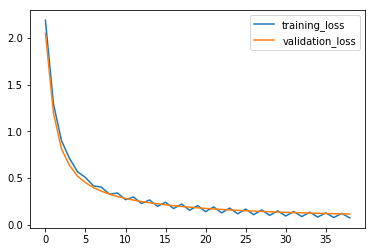

===============epoch:  19 =================
Training loss:  0.113886
Validation loss:  0.111451
Training accuracy:  0.966667
Validation accuracy:  0.966666


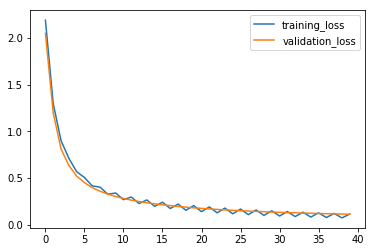

===============epoch:  20 =================
Training loss:  0.0680205
Validation loss:  0.109892
Training accuracy:  0.973333
Validation accuracy:  0.966428


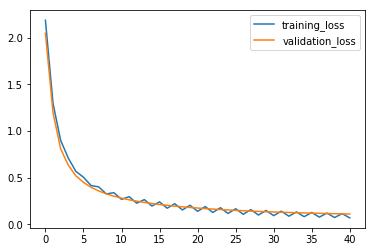

===============epoch:  20 =================
Training loss:  0.108297
Validation loss:  0.108143
Training accuracy:  0.97
Validation accuracy:  0.967381


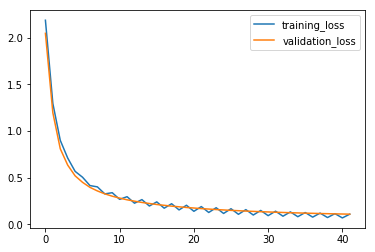

===============epoch:  21 =================
Training loss:  0.0644307
Validation loss:  0.106727
Training accuracy:  0.976667
Validation accuracy:  0.967619


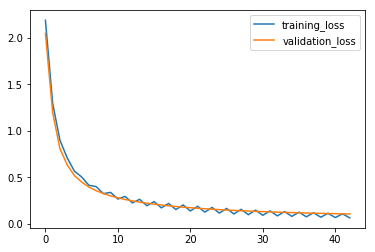

===============epoch:  21 =================
Training loss:  0.103042
Validation loss:  0.105157
Training accuracy:  0.971667
Validation accuracy:  0.967619


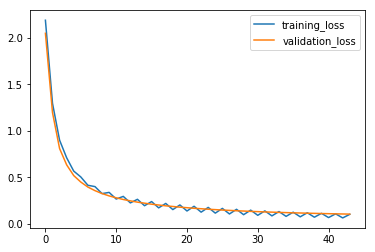

===============epoch:  22 =================
Training loss:  0.061171
Validation loss:  0.103872
Training accuracy:  0.978333
Validation accuracy:  0.968333


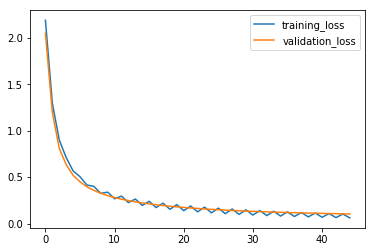

===============epoch:  22 =================
Training loss:  0.0980504
Validation loss:  0.102454
Training accuracy:  0.971667
Validation accuracy:  0.967857


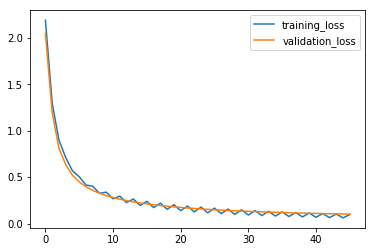

===============epoch:  23 =================
Training loss:  0.0581959
Validation loss:  0.101262
Training accuracy:  0.981667
Validation accuracy:  0.968809


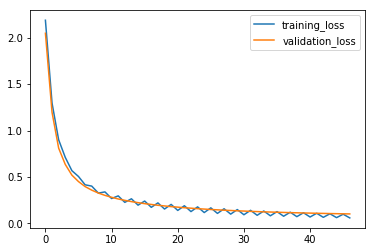

===============epoch:  23 =================
Training loss:  0.0933331
Validation loss:  0.0999527
Training accuracy:  0.971667
Validation accuracy:  0.968333


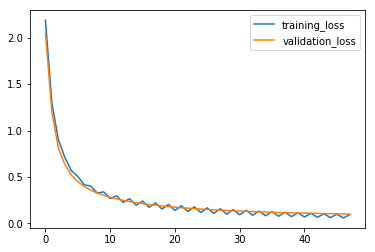

===============epoch:  24 =================
Training loss:  0.0554332
Validation loss:  0.0988432
Training accuracy:  0.981667
Validation accuracy:  0.968809


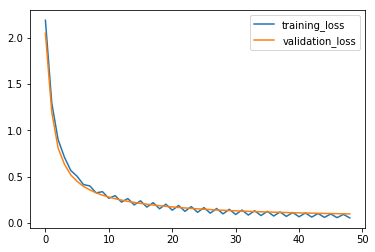

===============epoch:  24 =================
Training loss:  0.0888214
Validation loss:  0.0976334
Training accuracy:  0.973333
Validation accuracy:  0.969047


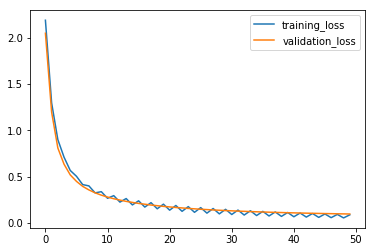

===============epoch:  25 =================
Training loss:  0.0528299
Validation loss:  0.0965915
Training accuracy:  0.981667
Validation accuracy:  0.969524


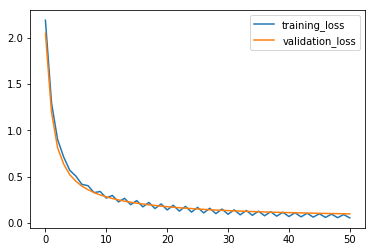

===============epoch:  25 =================
Training loss:  0.0844561
Validation loss:  0.0954775
Training accuracy:  0.976667
Validation accuracy:  0.969762


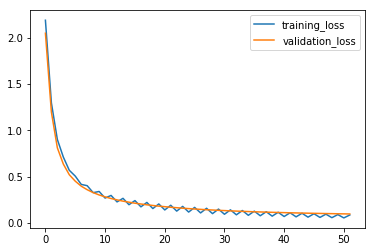

===============epoch:  26 =================
Training loss:  0.0504275
Validation loss:  0.0945095
Training accuracy:  0.981667
Validation accuracy:  0.969762


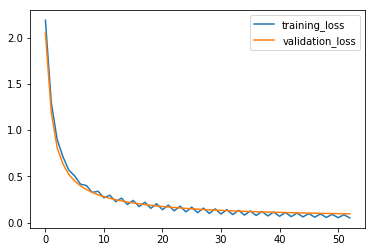

===============epoch:  26 =================
Training loss:  0.0803046
Validation loss:  0.0934878
Training accuracy:  0.976667
Validation accuracy:  0.969762


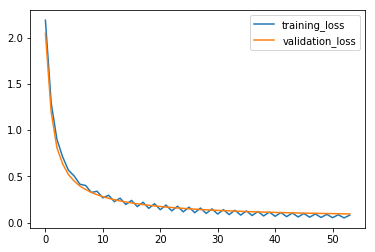

===============epoch:  27 =================
Training loss:  0.0482076
Validation loss:  0.0925844
Training accuracy:  0.983333
Validation accuracy:  0.970238


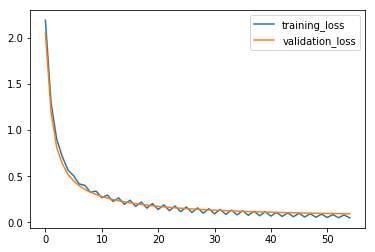

===============epoch:  27 =================
Training loss:  0.07638
Validation loss:  0.0916496
Training accuracy:  0.976667
Validation accuracy:  0.970952


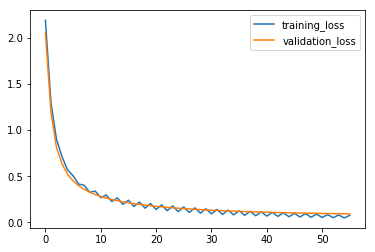

===============epoch:  28 =================
Training loss:  0.0461483
Validation loss:  0.0908087
Training accuracy:  0.988333
Validation accuracy:  0.970714


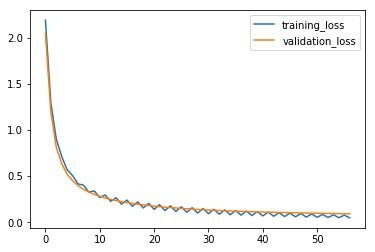

===============epoch:  28 =================
Training loss:  0.0726392
Validation loss:  0.0899412
Training accuracy:  0.976667
Validation accuracy:  0.971667


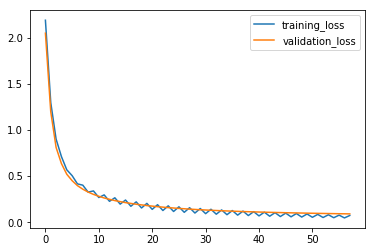

===============epoch:  29 =================
Training loss:  0.0442788
Validation loss:  0.089149
Training accuracy:  0.988333
Validation accuracy:  0.971667


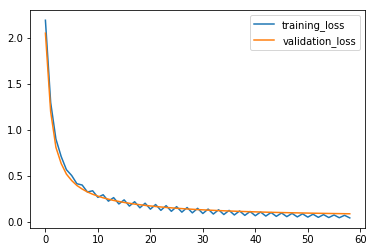

===============epoch:  29 =================
Training loss:  0.0691137
Validation loss:  0.088337
Training accuracy:  0.976667
Validation accuracy:  0.971428


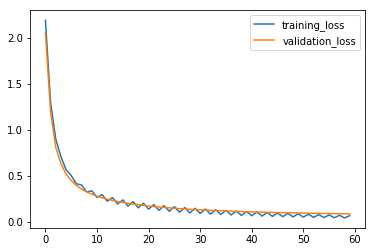

===============epoch:  30 =================
Training loss:  0.0425261
Validation loss:  0.0875776
Training accuracy:  0.991667
Validation accuracy:  0.971905


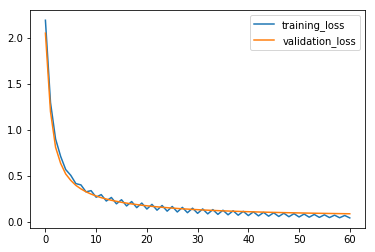

===============epoch:  30 =================
Training loss:  0.0657569
Validation loss:  0.0868249
Training accuracy:  0.981667
Validation accuracy:  0.971905


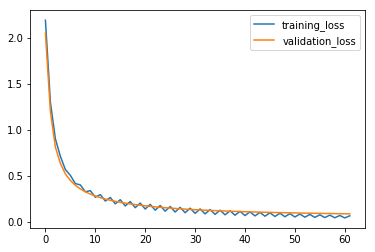

===============epoch:  31 =================
Training loss:  0.0408602
Validation loss:  0.086099
Training accuracy:  0.991667
Validation accuracy:  0.972381


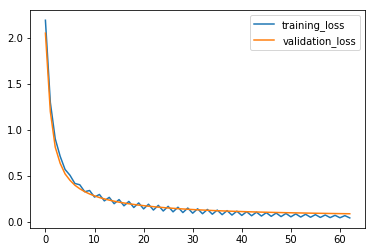

===============epoch:  31 =================
Training loss:  0.0625401
Validation loss:  0.0853962
Training accuracy:  0.983333
Validation accuracy:  0.971666


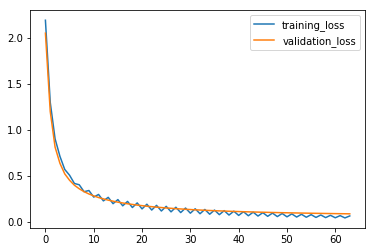

===============epoch:  32 =================
Training loss:  0.0392942
Validation loss:  0.0847063
Training accuracy:  0.993333
Validation accuracy:  0.972381


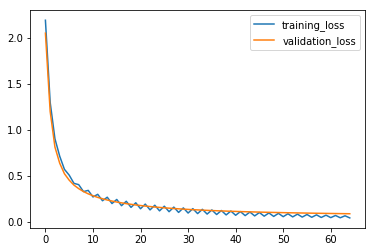

===============epoch:  32 =================
Training loss:  0.059482
Validation loss:  0.0840545
Training accuracy:  0.985
Validation accuracy:  0.971905


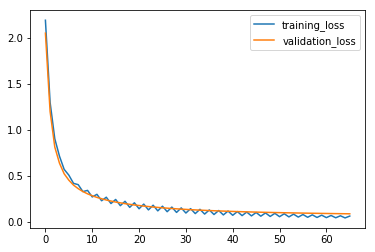

===============epoch:  33 =================
Training loss:  0.0378471
Validation loss:  0.083399
Training accuracy:  0.993333
Validation accuracy:  0.972381


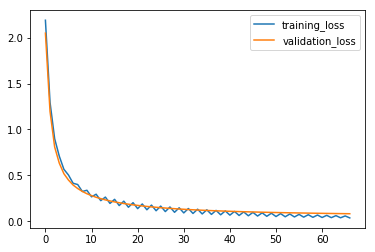

===============epoch:  33 =================
Training loss:  0.0565268
Validation loss:  0.082815
Training accuracy:  0.986667
Validation accuracy:  0.972381


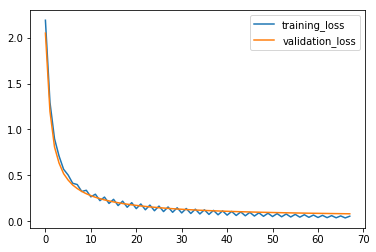

===============epoch:  34 =================
Training loss:  0.0364958
Validation loss:  0.0821754
Training accuracy:  0.993333
Validation accuracy:  0.972619


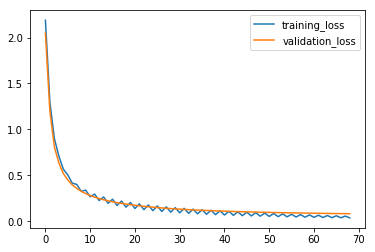

===============epoch:  34 =================
Training loss:  0.0537033
Validation loss:  0.0816535
Training accuracy:  0.986667
Validation accuracy:  0.973095


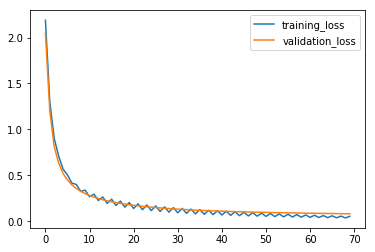

===============epoch:  35 =================
Training loss:  0.0351975
Validation loss:  0.0810148
Training accuracy:  0.993333
Validation accuracy:  0.972857


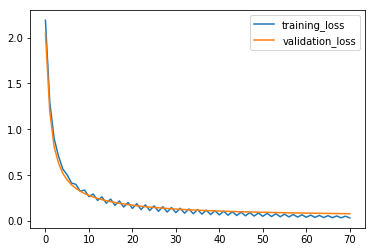

===============epoch:  35 =================
Training loss:  0.0509895
Validation loss:  0.0805421
Training accuracy:  0.986667
Validation accuracy:  0.973571


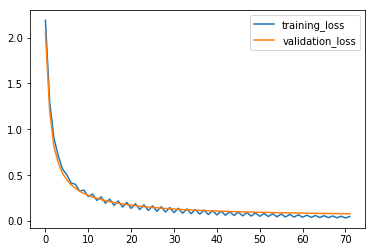

===============epoch:  36 =================
Training loss:  0.0339755
Validation loss:  0.0799222
Training accuracy:  0.993333
Validation accuracy:  0.973571


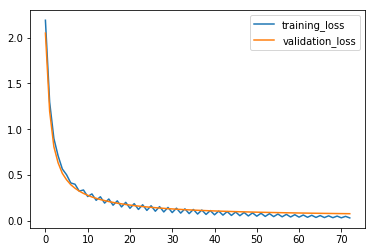

===============epoch:  36 =================
Training loss:  0.0484261
Validation loss:  0.0794965
Training accuracy:  0.988333
Validation accuracy:  0.973333


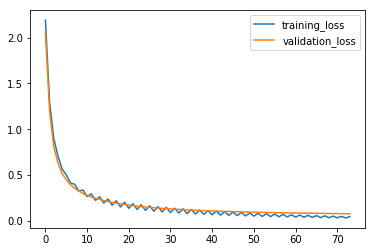

===============epoch:  37 =================
Training loss:  0.0327957
Validation loss:  0.0788859
Training accuracy:  0.993333
Validation accuracy:  0.974047


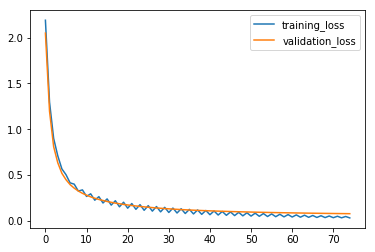

===============epoch:  37 =================
Training loss:  0.0460033
Validation loss:  0.0785077
Training accuracy:  0.988333
Validation accuracy:  0.973333


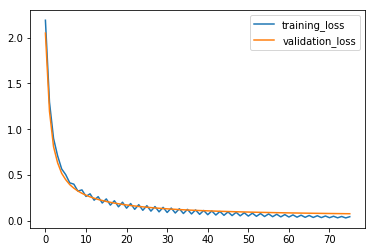

===============epoch:  38 =================
Training loss:  0.0316374
Validation loss:  0.0778894
Training accuracy:  0.993333
Validation accuracy:  0.975


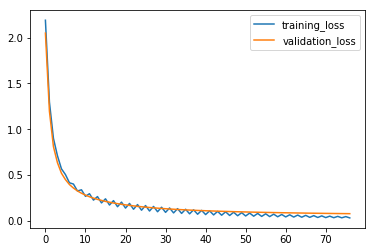

===============epoch:  38 =================
Training loss:  0.0436358
Validation loss:  0.0775471
Training accuracy:  0.99
Validation accuracy:  0.973571


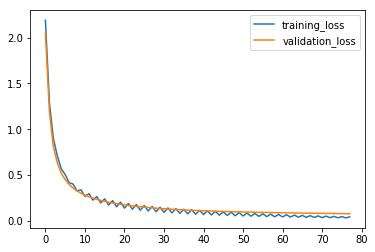

===============epoch:  39 =================
Training loss:  0.0305362
Validation loss:  0.0769563
Training accuracy:  0.995
Validation accuracy:  0.975476


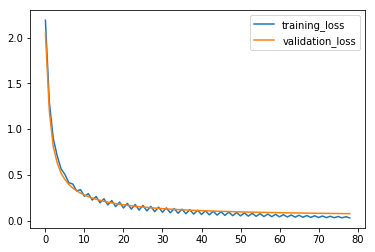

===============epoch:  39 =================
Training loss:  0.0413769
Validation loss:  0.0766624
Training accuracy:  0.991667
Validation accuracy:  0.974524


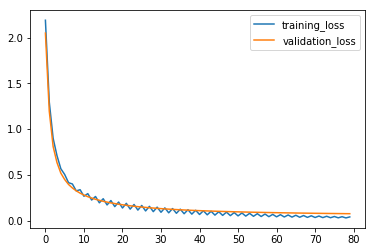

===============epoch:  40 =================
Training loss:  0.029502
Validation loss:  0.0760619
Training accuracy:  0.995
Validation accuracy:  0.975714


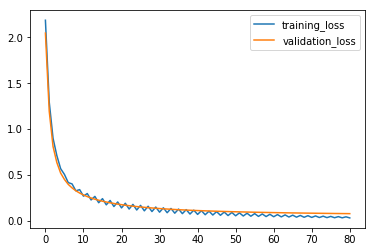

===============epoch:  40 =================
Training loss:  0.0392323
Validation loss:  0.075818
Training accuracy:  0.993333
Validation accuracy:  0.975


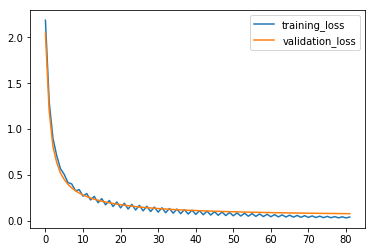

===============epoch:  41 =================
Training loss:  0.0285126
Validation loss:  0.0752172
Training accuracy:  0.995
Validation accuracy:  0.976428


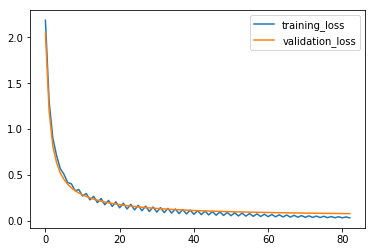

===============epoch:  41 =================
Training loss:  0.037179
Validation loss:  0.0750084
Training accuracy:  0.993333
Validation accuracy:  0.974762


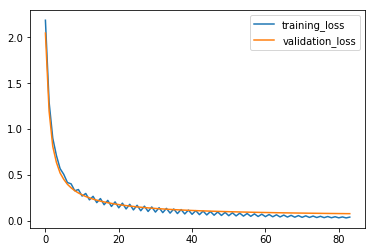

===============epoch:  42 =================
Training loss:  0.0275189
Validation loss:  0.0744219
Training accuracy:  0.995
Validation accuracy:  0.976667


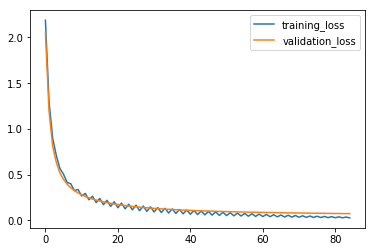

===============epoch:  42 =================
Training loss:  0.035169
Validation loss:  0.0742534
Training accuracy:  0.993333
Validation accuracy:  0.975714


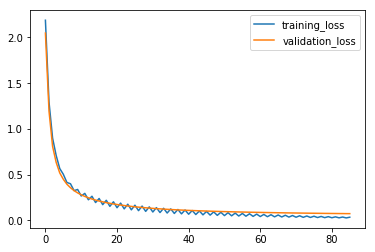

===============epoch:  43 =================
Training loss:  0.0265728
Validation loss:  0.073673
Training accuracy:  0.995
Validation accuracy:  0.976666


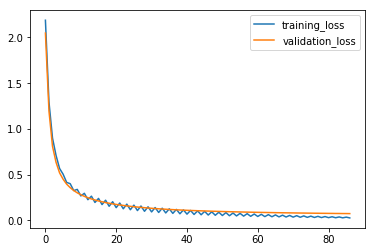

===============epoch:  43 =================
Training loss:  0.0332534
Validation loss:  0.0735361
Training accuracy:  0.993333
Validation accuracy:  0.975714


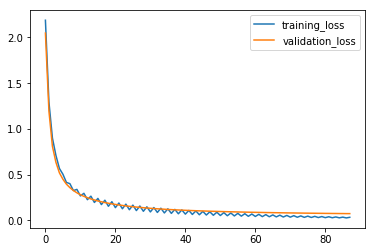

===============epoch:  44 =================
Training loss:  0.0256506
Validation loss:  0.0729502
Training accuracy:  0.995
Validation accuracy:  0.976905


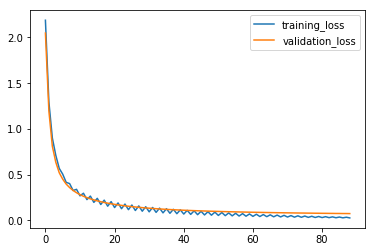

===============epoch:  44 =================
Training loss:  0.0314223
Validation loss:  0.0728559
Training accuracy:  0.993333
Validation accuracy:  0.976667


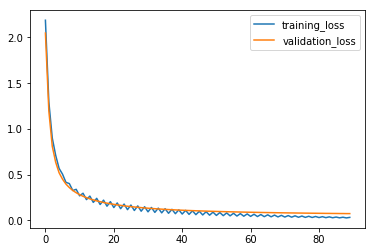

===============epoch:  45 =================
Training loss:  0.0247385
Validation loss:  0.072249
Training accuracy:  0.995
Validation accuracy:  0.977381


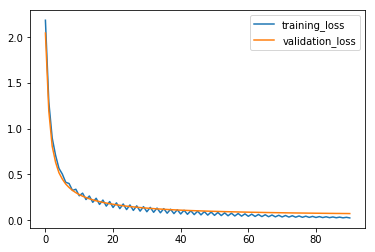

===============epoch:  45 =================
Training loss:  0.0296597
Validation loss:  0.072196
Training accuracy:  0.993333
Validation accuracy:  0.976905


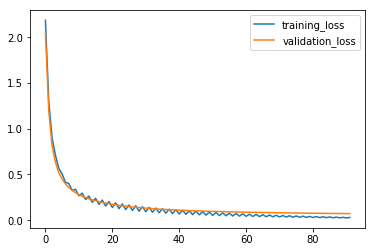

===============epoch:  46 =================
Training loss:  0.0238645
Validation loss:  0.0715791
Training accuracy:  0.995
Validation accuracy:  0.977857


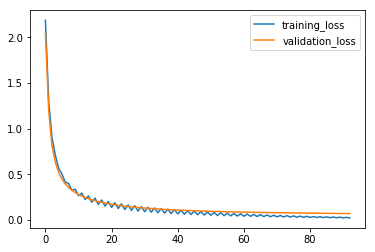

===============epoch:  46 =================
Training loss:  0.027971
Validation loss:  0.0715594
Training accuracy:  0.993333
Validation accuracy:  0.977143


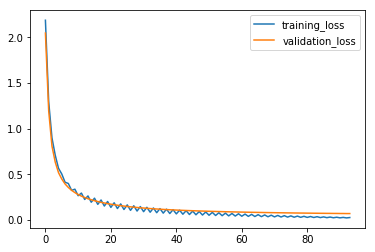

===============epoch:  47 =================
Training loss:  0.0230104
Validation loss:  0.0709328
Training accuracy:  0.995
Validation accuracy:  0.978095


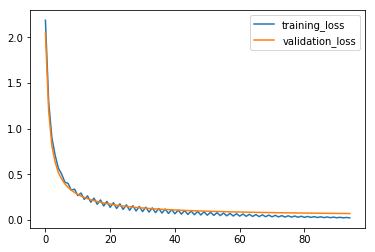

===============epoch:  47 =================
Training loss:  0.0263636
Validation loss:  0.0709525
Training accuracy:  0.993333
Validation accuracy:  0.977381


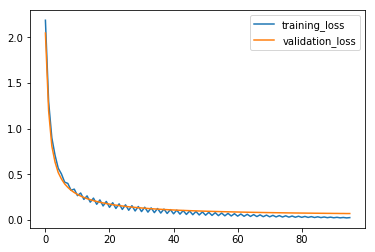

===============epoch:  48 =================
Training loss:  0.0221895
Validation loss:  0.0703105
Training accuracy:  0.995
Validation accuracy:  0.978095


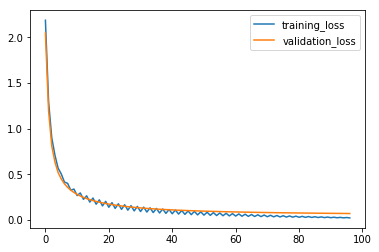

===============epoch:  48 =================
Training loss:  0.0248359
Validation loss:  0.0703686
Training accuracy:  0.993333
Validation accuracy:  0.977381


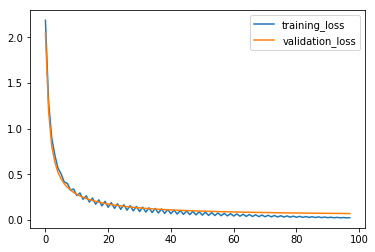

===============epoch:  49 =================
Training loss:  0.0213827
Validation loss:  0.0697265
Training accuracy:  0.995
Validation accuracy:  0.978333


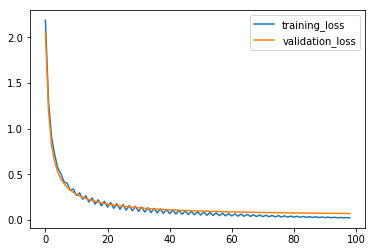

===============epoch:  49 =================
Training loss:  0.0233992
Validation loss:  0.0698296
Training accuracy:  0.993333
Validation accuracy:  0.977619


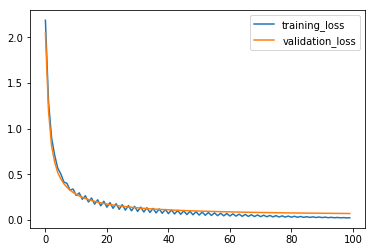

===============epoch:  50 =================
Training loss:  0.0205902
Validation loss:  0.0691738
Training accuracy:  0.995
Validation accuracy:  0.978571


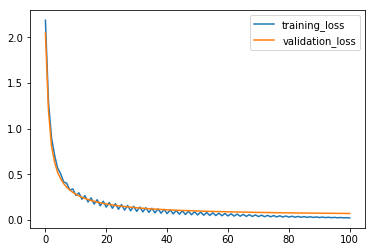

===============epoch:  50 =================
Training loss:  0.0220439
Validation loss:  0.0693246
Training accuracy:  0.993333
Validation accuracy:  0.978095


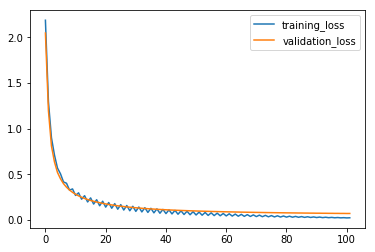

===============epoch:  51 =================
Training loss:  0.0198141
Validation loss:  0.0686454
Training accuracy:  0.995
Validation accuracy:  0.978571


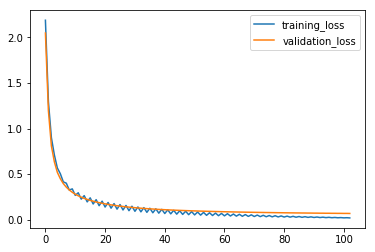

===============epoch:  51 =================
Training loss:  0.0207745
Validation loss:  0.0688296
Training accuracy:  0.995
Validation accuracy:  0.978571


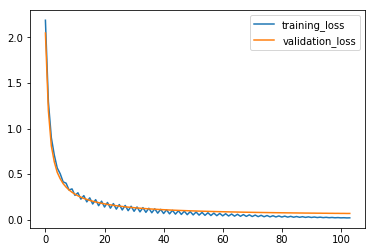

===============epoch:  52 =================
Training loss:  0.0190439
Validation loss:  0.0681386
Training accuracy:  0.995
Validation accuracy:  0.978333


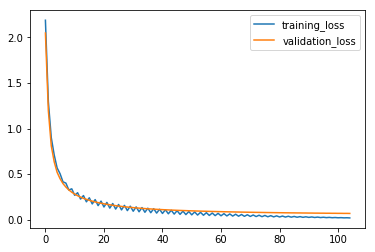

===============epoch:  52 =================
Training loss:  0.0195974
Validation loss:  0.0683672
Training accuracy:  0.995
Validation accuracy:  0.978571


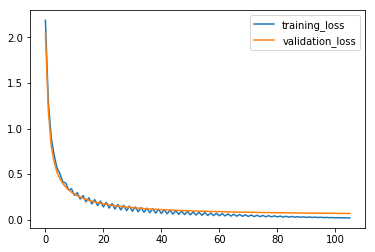

===============epoch:  53 =================
Training loss:  0.018307
Validation loss:  0.0676682
Training accuracy:  0.995
Validation accuracy:  0.978333


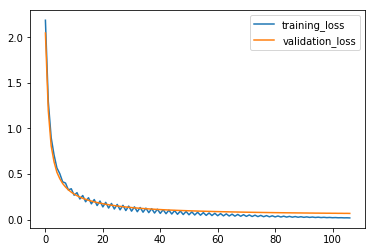

===============epoch:  53 =================
Training loss:  0.0184976
Validation loss:  0.0679179
Training accuracy:  0.996667
Validation accuracy:  0.978333


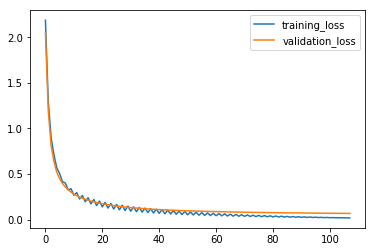

===============epoch:  54 =================
Training loss:  0.0175992
Validation loss:  0.067204
Training accuracy:  0.995
Validation accuracy:  0.978571


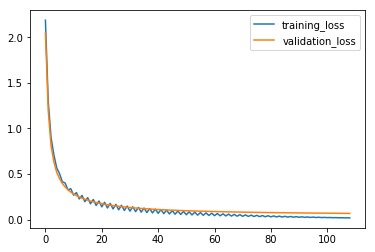

===============epoch:  54 =================
Training loss:  0.0174717
Validation loss:  0.0674942
Training accuracy:  0.996667
Validation accuracy:  0.978333


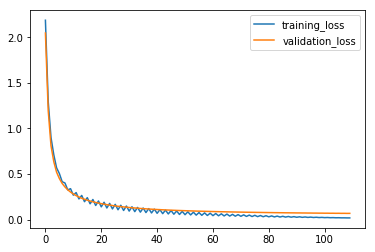

In [31]:
run_model(epochs, images, labels, batch_s, conv_dropout)

In [32]:
##############################################################
#                Part Five: Testing 
##############################################################

In [33]:
test_images = []

with open('test.csv') as test_file:
    # Skip first line.
    test_file.readline()
    
    csv_test_file = csv.reader(test_file, delimiter=',')
    for row in csv_test_file:
        test_images.append(np.array(row, dtype=float))

In [34]:
t_offset = 1

with open('test_output.csv', 'w') as test_output:
    test_output.write('ImageId,Label\n')
    
    test_loader = BatchLoader(test_images)

    
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
        
        loaded_image_tensor = loaded_graph.get_tensor_by_name("conv_input:0")
        loaded_label_tensor = loaded_graph.get_tensor_by_name("conv_label:0")
        loaded_dropout_prob = loaded_graph.get_tensor_by_name("dropout_prob:0")
        loaded_logits = loaded_graph.get_tensor_by_name("logits:0")
    
        while True:
            test_image_batch = test_loader.load_batch_image(600)
            
            if len(test_image_batch) == 0:
                break
            
            labels = sess.run(loaded_logits, feed_dict={
                loaded_image_tensor: test_image_batch,
                loaded_dropout_prob: 0.0
            })
        
            labels = np.argmax(labels, axis=1)
        
            data = zip(range(t_offset, t_offset + len(labels)), labels)
        
            for d in data:
                test_output.write('%d,%d\n' % d)
            
            t_offset += len(labels)
        

INFO:tensorflow:Restoring parameters from ./kaggle_digit
